In [1]:
from qm import QuantumMachinesManager, QopCaps
from qm.qua import *
from configuration import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

2025-08-18 11:02:42,833 - qm - INFO     - Starting session: bfca8e73-c567-4081-a1ca-ae88e34a2b4d


In [2]:
def find_delay(adc):
    # Filter the data to get the pulse arrival time
    signal = savgol_filter(np.abs(adc), 11, 3)
    # Detect the arrival of the readout signal
    th = (np.mean(signal[:100]) + np.mean(signal[:-100])) / 2
    delay = np.where(signal > th)[0][0]
    delay = np.round(delay / 4) * 4  # Find the closest multiple integer of 4ns
    print(f"delay = {delay}ns")
    return delay

def plot_adc(adc,adc_single_run,delay):
    fig = plt.figure()
    plt.subplot(121)
    plt.title("Single run")
    plt.plot(adc_single_run.real, "b", label="I")
    plt.plot(adc_single_run.imag, "r", label="Q")
    xl = plt.xlim()
    yl = plt.ylim()
    plt.axvline(delay, color="k", linestyle="--", label="TOF")
    plt.fill_between(range(len(adc_single_run)), -0.5, 0.5, color="grey", alpha=0.2, label="ADC Range")
    plt.xlabel("Time [ns]")
    plt.ylabel("Signal amplitude [V]")
    plt.legend()
    plt.subplot(122)
    plt.title("Averaged run")
    plt.plot(adc.real, "b", label="I")
    plt.plot(adc.imag, "r", label="Q")
    plt.axvline(delay, color="k", linestyle="--", label="TOF")
    plt.xlabel("Time [ns]")
    plt.legend()
    plt.grid("all")
    plt.tight_layout()
    plt.show()
    return fig

In [3]:
resonator = "rr1"
n_avg = 100  # The number of averages

with program() as raw_trace_prog:
    n = declare(int)  # QUA variable for the averaging loop
    adc_st = declare_stream(adc_trace=True)  # The stream to store the raw ADC trace

    with for_(n, 0, n < n_avg, n + 1):
        # Reset the phase of the digital oscillator associated to the resonator element. Needed to average the cosine signal.
        reset_if_phase(resonator)
        # Sends the readout pulse and stores the raw ADC traces in the stream called "adc_st"
        measure("readout", resonator, adc_stream = adc_st)
        # Wait for the resonator to deplete
        wait(depletion_time * u.ns, resonator)

    with stream_processing():
        # Will save average:
        adc_st.input1().average().save("adc")
        # Will save only last run:
        adc_st.input1().save("adc_single_run")



In [4]:
qop_ip = "172.16.33.116" 
cluster_name = "CS_DGX" 
qmm = QuantumMachinesManager(host=qop_ip,port=None, cluster_name=cluster_name)

2025-08-18 11:02:53,699 - qm - INFO     - Performing health check
2025-08-18 11:02:54,115 - qm - INFO     - Cluster healthcheck completed successfully.


In [5]:
# Open a quantum machine to execute the QUA program
qm = qmm.open_qm(full_config,close_other_machines=True)
# Send the QUA program to the OPX, which compiles and executes it
job = qm.execute(raw_trace_prog)
# Creates a result handle to fetch data from the OPX
res_handles = job.result_handles
# Waits (blocks the Python console) until all results have been acquired
results = res_handles.fetch_results(wait_until_done=True, timeout=60,stream_names=["adc","adc_single_run"])
# Fetch the raw ADC traces and convert them into Volts
adc = u.raw2volts(results.get("adc")[0][0])
adc_single_run = u.raw2volts(results.get("adc_single_run")[0][0])


c:\Users\JackChao\miniconda3\envs\qop350\Lib\site-packages\qm\program\_qua_config_schema.py:1894: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


2025-08-18 11:02:55,755 - qm - INFO     - Clearing queue
2025-08-18 11:02:56,541 - qm - INFO     - Adding program to queue.
2025-08-18 11:02:58,203 - qm - INFO     - Job 5278c681-aa29-446c-981c-5a3920ef3e81 is done


delay = 292.0ns


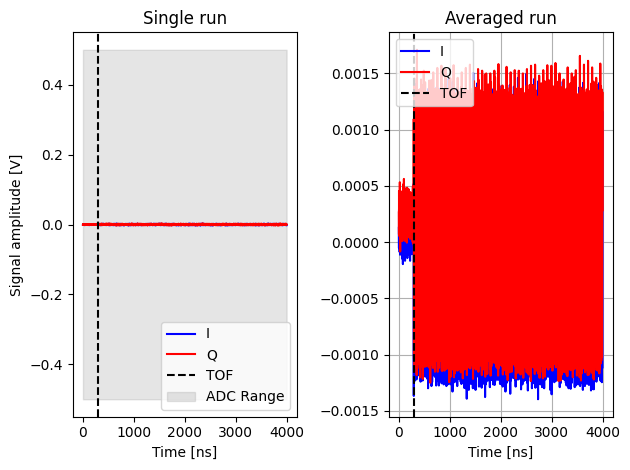

In [6]:
# find delay
delay = find_delay(adc)
# Plot data
fig = plot_adc(adc,adc_single_run,delay)


In [7]:
logical_config["elements"]['rr1']["time_of_flight"] += int(delay)

job2 = qm.execute(raw_trace_prog,config=logical_config)
# Creates a result handle to fetch data from the OPX
res_handles = job2.result_handles
# Waits (blocks the Python console) until all results have been acquired
results = res_handles.fetch_results(wait_until_done=True, timeout=60,stream_names=["adc","adc_single_run"])
# Fetch the raw ADC traces and convert them into Volts
adc = u.raw2volts(results.get("adc")[0][0])
adc_single_run = u.raw2volts(results.get("adc_single_run")[0][0])

2025-08-18 11:03:15,042 - qm - INFO     - Clearing queue
2025-08-18 11:03:15,817 - qm - INFO     - Adding program to queue.
2025-08-18 11:03:17,353 - qm - INFO     - Job 36b5616e-325e-4bf2-841e-6eeaceb2693f is done


delay = 0.0ns


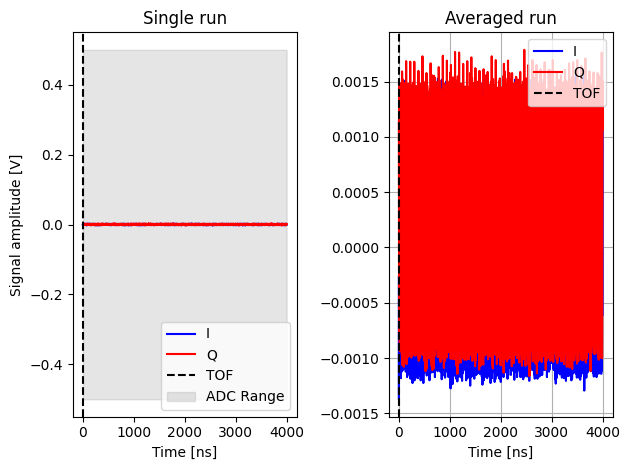

In [8]:
# find delay
delay = find_delay(adc)
# Plot data
fig = plot_adc(adc,adc_single_run,delay)

In [9]:
full_config = controller_config | logical_config # store your config with calibrated values
qm.close()

True